<h1> Objective:- Assessment Task 5: Machine Learning Project. </h1>

<div style="text-align: right"> Owner: <b>Karan Murjani </b> </div>

<h6> Importing all the required libraries </h6>

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedShuffleSplit, ShuffleSplit
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import seaborn as sns
import time
from sklearn import metrics
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

os.chdir('/Users/karanmurjani/Downloads/Study/Trimester 2/SIT720 - Machine Learning/Assignment5/')

In [2]:
patient_df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
print(patient_df.shape)
patient_df.head()

(299, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
#Checking if there is any null values.
def check_missing(df):
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum()/len(df)
    missing_table = pd.concat([null_val, percent], axis=1)
    col = missing_table.rename(columns = {0 : 'Num', 1 : 'Rate'})
    return col

# Display columns missing values are under 1%.
print("Number of rows :- "+str(len(patient_df)))
cols = check_missing(patient_df)
cols.sort_values(by="Rate", ascending=False)

Number of rows :- 299


,Num,Rate
age,0,0.0
anaemia,0,0.0
creatinine_phosphokinase,0,0.0
diabetes,0,0.0
ejection_fraction,0,0.0
high_blood_pressure,0,0.0
platelets,0,0.0
serum_creatinine,0,0.0
serum_sodium,0,0.0
sex,0,0.0


In [4]:
X = patient_df.loc[:,patient_df.columns!="DEATH_EVENT"]
X = X.loc[:,X.columns!="time"]
y = patient_df['DEATH_EVENT'] 

print(X.shape)
print(y.shape)

(299, 11)
(299,)


In [5]:
y.value_counts() #Imbalance class

0    203
1     96
Name: DEATH_EVENT, dtype: int64

In [6]:
#Make metrics dataset
metrics_df = pd.DataFrame({
    'Model' : [],
    'Accuracy' : [],
    'ROC_AUC' : [],
    'F1_Score' : [],
    'MCC' : [],
    'TPR' : [],
    'TNR' : []
})
metrics_df

,Model,Accuracy,ROC_AUC,F1_Score,MCC,TPR,TNR


<h6> Model Building

In [7]:
Classifiers = [
    RandomForestClassifier(random_state=123),
    DecisionTreeClassifier(random_state=123), 
    GradientBoostingClassifier(random_state=123),
    GaussianNB(),
    XGBClassifier(eta = 1, max_depth = 2, nthread=2, num_round=2,verbosity=0, random_state=123), 
]


kf = ShuffleSplit(n_splits = 100, random_state=123,test_size=0.2)
roc_score_list =[]
accuracy_score_list = []
f1_score_list = []
mcc_score_list = []
tpr_list = []
tnr_list = []
avg_auc_list = []
row_index=0
for classifier in Classifiers:
    metrics_df.loc[row_index, 'Model'] = classifier.__class__.__name__
    i=1
    for train_index,test_index in kf.split(X,y):
        X_train, X_test = X.loc[train_index],X.loc[test_index]
        y_train,y_test = y.loc[train_index],y.loc[test_index]

        #Model
        model = classifier
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        #ROC_AUC
        roc_score = roc_auc_score(y_test, y_pred)
        roc_score_list.append(roc_score)    

        #Accuracy
        accuracy_score_lr = metrics.accuracy_score(y_test, y_pred)
        accuracy_score_list.append(accuracy_score_lr)

        #F1-Score
        f1_score = metrics.f1_score(y_test, y_pred)
        f1_score_list.append(f1_score)

        #MCC
        mcc_score = metrics.matthews_corrcoef(y_test, y_pred)
        mcc_score_list.append(mcc_score)
        
         # compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        tpr = tp/(tp + fn)
        tpr_list.append(tpr)
        
        # specificity, selectivity or true negative rate (TNR)
        tnr = tn/(tn + fp)
        tnr_list.append(tnr)
        
        #PR-AUC
        average_precision = metrics.average_precision_score(y_test, y_pred)
        avg_auc_list.append(average_precision)
        
        i+=1
    metrics_df.loc[row_index, 'Accuracy'] = round(np.mean(accuracy_score_lr) * 100,2) 
    metrics_df.loc[row_index, 'ROC_AUC'] = round(np.mean(roc_score_list) * 100, 2)
    metrics_df.loc[row_index, 'F1_Score'] = round(np.mean(f1_score_list) * 100, 2)
    metrics_df.loc[row_index, 'MCC'] = round(np.mean(mcc_score_list) * 100, 2)
    metrics_df.loc[row_index, 'TPR'] = round(np.mean(tpr_list) * 100, 2)
    metrics_df.loc[row_index, 'TNR'] = round(np.mean(tnr_list) * 100, 2)
    metrics_df.loc[row_index, 'PR_AUC'] = round(np.mean(avg_auc_list) * 100, 2)
    
    row_index+=1

In [8]:
metrics_df

,Model,Accuracy,ROC_AUC,F1_Score,MCC,TPR,TNR,PR_AUC
0,RandomForestClassifier,78.33,67.59,53.79,38.34,48.10,87.08,48.27
1,DecisionTreeClassifier,71.67,65.35,51.40,32.44,48.45,82.26,45.23
2,GradientBoostingClassifier,71.67,65.94,52.16,33.71,48.85,83.02,45.85
3,GaussianNB,71.67,63.94,47.12,30.98,42.28,85.61,44.44
4,XGBClassifier,61.67,64.20,48.02,31.00,43.87,84.53,44.44


<h6> Random Forest with Random Oversampling

In [9]:
#Random Forest with ROSE
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_sample(X, y)
y_res.value_counts()

0    203
1    203
Name: DEATH_EVENT, dtype: int64

In [10]:
Classifiers = [
    RandomForestClassifier(random_state=123),
]

kf = ShuffleSplit(n_splits = 100, random_state=123, test_size=0.2)
roc_score_rf =[]
accuracy_score_rf = []
f1_score_rf = []
mcc_score_rf = []
tpr_rf = []
tnr_rf = []
avg_auc_rf = []

row_index=5 #Adding to next row
for classifier in Classifiers:
    metrics_df.loc[row_index, 'Model'] = classifier.__class__.__name__ + ' ' + 'ROSE'
    i=1
    for train_index,test_index in kf.split(X_res,y_res):
        X_train, X_test = X_res.loc[train_index],X_res.loc[test_index]
        y_train,y_test = y_res.loc[train_index],y_res.loc[test_index]

        #Model
        model = classifier
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        #ROC_AUC
        roc_score = roc_auc_score(y_test, y_pred)
        roc_score_rf.append(roc_score)    

        #Accuracy
        accuracy_score_lr = metrics.accuracy_score(y_test, y_pred)
        accuracy_score_rf.append(accuracy_score_lr)

        #F1-Score
        f1_score = metrics.f1_score(y_test, y_pred)
        f1_score_rf.append(f1_score)

        #MCC
        mcc_score = metrics.matthews_corrcoef(y_test, y_pred)
        mcc_score_rf.append(mcc_score)
        
         # compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        tpr = tp/(tp + fn)
        tpr_rf.append(tpr)
        
        # specificity, selectivity or true negative rate (TNR)
        tnr = tn/(tn + fp)
        tnr_rf.append(tnr)
        
        #PR-AUC
        average_precision = metrics.average_precision_score(y_test, y_pred)
        avg_auc_rf.append(average_precision)
        
        i+=1
    metrics_df.loc[row_index, 'Accuracy'] = round(np.mean(accuracy_score_lr) * 100,2) 
    metrics_df.loc[row_index, 'ROC_AUC'] = round(np.mean(roc_score_rf) * 100, 2)
    metrics_df.loc[row_index, 'F1_Score'] = round(np.mean(f1_score_rf) * 100, 2)
    metrics_df.loc[row_index, 'MCC'] = round(np.mean(mcc_score_rf) * 100, 2)
    metrics_df.loc[row_index, 'TPR'] = round(np.mean(tpr_rf) * 100, 2)
    metrics_df.loc[row_index, 'TNR'] = round(np.mean(tnr_rf) * 100, 2)
    metrics_df.loc[row_index, 'PR_AUC'] = round(np.mean(avg_auc_rf) * 100, 2)
    
    row_index+=1

In [11]:
metrics_df

,Model,Accuracy,ROC_AUC,F1_Score,MCC,TPR,TNR,PR_AUC
0,RandomForestClassifier,78.33,67.59,53.79,38.34,48.10,87.08,48.27
1,DecisionTreeClassifier,71.67,65.35,51.40,32.44,48.45,82.26,45.23
2,GradientBoostingClassifier,71.67,65.94,52.16,33.71,48.85,83.02,45.85
3,GaussianNB,71.67,63.94,47.12,30.98,42.28,85.61,44.44
4,XGBClassifier,61.67,64.20,48.02,31.00,43.87,84.53,44.44
5,RandomForestClassifier ROSE,84.15,85.46,85.70,71.13,89.44,81.48,79.11


<h6> Linear Regression

In [12]:
Classifiers = [
    LinearRegression(),
]

kf = StratifiedShuffleSplit(n_splits = 100, random_state = 100, test_size=0.2)
roc_score_lr =[]
accuracy_score_lr = []
f1_score_lr = []
mcc_score_lr = []
tpr_lr = []
tnr_lr = []
avg_auc_lr = []

row_index=6 #Adding to next row
for classifier in Classifiers:
    metrics_df.loc[row_index, 'Model'] = classifier.__class__.__name__ 
    i=1
    for train_index,test_index in kf.split(X,y):
        X_train, X_test = X.loc[train_index],X.loc[test_index]
        y_train,y_test = y.loc[train_index],y.loc[test_index]

        #Model
        model = classifier
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_lr = np.where(y_pred >0.5, 1, 0)

        #ROC_AUC
        roc_score = roc_auc_score(y_test, y_pred_lr)
        roc_score_lr.append(roc_score)    

        #Accuracy
        accuracy_score_list = metrics.accuracy_score(y_test, y_pred_lr)
        accuracy_score_lr.append(accuracy_score_list)

        #F1-Score
        f1_score = metrics.f1_score(y_test, y_pred_lr)
        f1_score_lr.append(f1_score)

        #MCC
        mcc_score = metrics.matthews_corrcoef(y_test, y_pred_lr)
        mcc_score_lr.append(mcc_score)
        
         # compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()
        tpr = tp/(tp + fn)
        tpr_lr.append(tpr)
        
        # specificity, selectivity or true negative rate (TNR)
        tnr = tn/(tn + fp)
        tnr_lr.append(tnr)
        
        #PR-AUC
        average_precision = metrics.average_precision_score(y_test, y_pred_lr)
        avg_auc_lr.append(average_precision)
        
        i+=1
    metrics_df.loc[row_index, 'Accuracy'] = round(np.mean(accuracy_score_lr) * 100,2) 
    metrics_df.loc[row_index, 'ROC_AUC'] = round(np.mean(roc_score_lr) * 100, 2)
    metrics_df.loc[row_index, 'F1_Score'] = round(np.mean(f1_score_lr) * 100, 2)
    metrics_df.loc[row_index, 'MCC'] = round(np.mean(mcc_score_lr) * 100, 2)
    metrics_df.loc[row_index, 'TPR'] = round(np.mean(tpr_lr) * 100, 2)
    metrics_df.loc[row_index, 'TNR'] = round(np.mean(tnr_lr) * 100, 2)
    metrics_df.loc[row_index, 'PR_AUC'] = round(np.mean(avg_auc_lr) * 100, 2)
    
    row_index+=1

In [13]:
metrics_df

,Model,Accuracy,ROC_AUC,F1_Score,MCC,TPR,TNR,PR_AUC
0,RandomForestClassifier,78.33,67.59,53.79,38.34,48.10,87.08,48.27
1,DecisionTreeClassifier,71.67,65.35,51.40,32.44,48.45,82.26,45.23
2,GradientBoostingClassifier,71.67,65.94,52.16,33.71,48.85,83.02,45.85
3,GaussianNB,71.67,63.94,47.12,30.98,42.28,85.61,44.44
4,XGBClassifier,61.67,64.20,48.02,31.00,43.87,84.53,44.44
5,RandomForestClassifier ROSE,84.15,85.46,85.70,71.13,89.44,81.48,79.11
6,LinearRegression,74.28,65.73,50.68,36.29,42.42,89.05,46.35


<h6> KNN with Hyperparameter tuning

In [14]:
#Make knn hyperparameter metrics dataset

knn_hyper_df = pd.DataFrame({
    'K' : [],
    'Model' : [],
    'Accuracy' : [],
    'ROC_AUC' : [],
    'F1_Score' : [],
    'MCC' : [],
    'TPR' : [],
    'TNR' : []
})
knn_hyper_df

,K,Model,Accuracy,ROC_AUC,F1_Score,MCC,TPR,TNR


In [15]:
kf = ShuffleSplit(n_splits = 100, random_state = 100, test_size=0.2, train_size=0.6)
roc_score_knn =[]
accuracy_score_knn = []
f1_score_knn = []
mcc_score_knn = []
tpr_knn = []
tnr_knn = []
avg_auc_knn = []

row_index=0 #Adding to next row
iteration = 1

knn_hyper_df.loc[row_index, 'Model'] = 'KNN'
for train_index,test_index in kf.split(X,y):
    X_train, X_test = X.loc[train_index],X.loc[test_index]
    y_train,y_test = y.loc[train_index],y.loc[test_index]
    
    indexes = X_train.index.to_list() + X_test.index.to_list() #Train and Test indexes to get validation set
    X_validate = X[~X.index.isin(indexes)]
    y_validate = y[~y.index.isin(indexes)]
    
    for i in range(1,101):
        knn_hyper_df.loc[row_index, 'K'] = i
        #Model
        model = KNeighborsClassifier(n_neighbors=i)
        model.fit(X_train, y_train)
        y_pred_knn = model.predict(X_validate)

        #ROC_AUC
        roc_score = roc_auc_score(y_validate, y_pred_knn)
        roc_score_knn.append(roc_score)    

        #Accuracy
        accuracy_score_list = metrics.accuracy_score(y_validate, y_pred_knn)
        accuracy_score_knn.append(accuracy_score_list)

        #F1-Score
        f1_score = metrics.f1_score(y_validate, y_pred_knn)
        f1_score_knn.append(f1_score)

        #MCC
        mcc_score = metrics.matthews_corrcoef(y_validate, y_pred_knn)
        mcc_score_knn.append(mcc_score)

         # compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_validate, y_pred_knn).ravel()
        tpr = tp/(tp + fn)
        tpr_knn.append(tpr)

        # specificity, selectivity or true negative rate (TNR)
        tnr = tn/(tn + fp)
        tnr_knn.append(tnr)

        #PR-AUC
        average_precision = metrics.average_precision_score(y_validate, y_pred_knn)
        avg_auc_knn.append(average_precision)
        
        knn_hyper_df.loc[row_index, 'Accuracy'] = round(accuracy_score_list * 100, 2)
        knn_hyper_df.loc[row_index, 'ROC_AUC'] = round(roc_score * 100, 2)
        knn_hyper_df.loc[row_index, 'MCC'] = round(mcc_score * 100, 2)
        
        row_index+=1
        
    iteration+=1

In [16]:
#Grouping all the iteration by K and selecting best MCC Score value
knn_hyper_df.groupby('K').agg({'MCC':np.mean}).reset_index().sort_values(by='MCC', ascending=False).head(1)

,K,MCC
4,5.0,3.4302


Building model with best K value - number of neighbours value.

In [17]:
Classifiers = [
    KNeighborsClassifier(n_neighbors=5),
]

kf = ShuffleSplit(n_splits = 100, random_state = 100, test_size=0.2, train_size=0.6)
roc_score_knn =[]
accuracy_score_knn = []
f1_score_knn = []
mcc_score_knn = []
tpr_knn = []
tnr_knn = []
avg_auc_knn = []

row_index=7 #Adding to next row
for classifier in Classifiers:
    metrics_df.loc[row_index, 'Model'] = classifier.__class__.__name__ 
    i=1
    for train_index,test_index in kf.split(X,y):
        X_train, X_test = X.loc[train_index],X.loc[test_index]
        y_train,y_test = y.loc[train_index],y.loc[test_index]
        
        indexes = X_train.index.to_list() + X_test.index.to_list() #Train and Test indexes to get validation set
        X_validate = X[~X.index.isin(indexes)]
        y_validate = y[~y.index.isin(indexes)]

        #Model
        model = classifier
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        #ROC_AUC
        roc_score = roc_auc_score(y_test, y_pred)
        roc_score_knn.append(roc_score)    

        #Accuracy
        accuracy_score_list = metrics.accuracy_score(y_test, y_pred)
        accuracy_score_knn.append(accuracy_score_list)

        #F1-Score
        f1_score = metrics.f1_score(y_test, y_pred)
        f1_score_knn.append(f1_score)

        #MCC
        mcc_score = metrics.matthews_corrcoef(y_test, y_pred)
        mcc_score_knn.append(mcc_score)
        
         # compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        tpr = tp/(tp + fn)
        tpr_knn.append(tpr)
        
        # specificity, selectivity or true negative rate (TNR)
        tnr = tn/(tn + fp)
        tnr_knn.append(tnr)
        
        #PR-AUC
        average_precision = metrics.average_precision_score(y_test, y_pred)
        avg_auc_knn.append(average_precision)
        
        i+=1
    metrics_df.loc[row_index, 'Accuracy'] = round(np.mean(accuracy_score_knn) * 100,2) 
    metrics_df.loc[row_index, 'ROC_AUC'] = round(np.mean(roc_score_knn) * 100, 2)
    metrics_df.loc[row_index, 'F1_Score'] = round(np.mean(f1_score_knn) * 100, 2)
    metrics_df.loc[row_index, 'MCC'] = round(np.mean(mcc_score_knn) * 100, 2)
    metrics_df.loc[row_index, 'TPR'] = round(np.mean(tpr_knn) * 100, 2)
    metrics_df.loc[row_index, 'TNR'] = round(np.mean(tnr_knn) * 100, 2)
    metrics_df.loc[row_index, 'PR_AUC'] = round(np.mean(avg_auc_knn) * 100, 2)
    
    row_index+=1

In [18]:
metrics_df

,Model,Accuracy,ROC_AUC,F1_Score,MCC,TPR,TNR,PR_AUC
0,RandomForestClassifier,78.33,67.59,53.79,38.34,48.10,87.08,48.27
1,DecisionTreeClassifier,71.67,65.35,51.40,32.44,48.45,82.26,45.23
2,GradientBoostingClassifier,71.67,65.94,52.16,33.71,48.85,83.02,45.85
3,GaussianNB,71.67,63.94,47.12,30.98,42.28,85.61,44.44
4,XGBClassifier,61.67,64.20,48.02,31.00,43.87,84.53,44.44
5,RandomForestClassifier ROSE,84.15,85.46,85.70,71.13,89.44,81.48,79.11
6,LinearRegression,74.28,65.73,50.68,36.29,42.42,89.05,46.35
7,KNeighborsClassifier,61.72,51.03,24.30,2.57,19.95,82.10,33.77


<h6> One Rule Classifier

In [19]:
Classifiers = [
    DecisionTreeClassifier(max_depth=1, random_state=123), #OneR classifier is Decision Tree with depth of 1
]

kf = StratifiedShuffleSplit(n_splits = 100, random_state = 100, test_size=0.2)
roc_score_oner =[]
accuracy_score_oner = []
f1_score_oner = []
mcc_score_oner = []
tpr_oner = []
tnr_oner = []
avg_auc_oner = []

row_index=8 #Adding to next row
for classifier in Classifiers:
    metrics_df.loc[row_index, 'Model'] = 'OneR Classifier'
    i=1
    for train_index,test_index in kf.split(X,y):
        X_train, X_test = X.loc[train_index],X.loc[test_index]
        y_train,y_test = y.loc[train_index],y.loc[test_index]

        #Model
        model = classifier
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_oner = np.where(y_pred >0.5, 1, 0)

        #ROC_AUC
        roc_score = roc_auc_score(y_test, y_pred_oner)
        roc_score_oner.append(roc_score)    

        #Accuracy
        accuracy_score_list = metrics.accuracy_score(y_test, y_pred_oner)
        accuracy_score_oner.append(accuracy_score_list)

        #F1-Score
        f1_score = metrics.f1_score(y_test, y_pred_oner)
        f1_score_oner.append(f1_score)

        #MCC
        mcc_score = metrics.matthews_corrcoef(y_test, y_pred_oner)
        mcc_score_oner.append(mcc_score)
        
         # compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_oner).ravel()
        tpr = tp/(tp + fn)
        tpr_oner.append(tpr)
        
        # specificity, selectivity or true negative rate (TNR)
        tnr = tn/(tn + fp)
        tnr_oner.append(tnr)
        
        #PR-AUC
        average_precision = metrics.average_precision_score(y_test, y_pred_oner)
        avg_auc_oner.append(average_precision)
        
        i+=1
    metrics_df.loc[row_index, 'Accuracy'] = round(np.mean(accuracy_score_oner) * 100,2) 
    metrics_df.loc[row_index, 'ROC_AUC'] = round(np.mean(roc_score_oner) * 100, 2)
    metrics_df.loc[row_index, 'F1_Score'] = round(np.mean(f1_score_oner) * 100, 2)
    metrics_df.loc[row_index, 'MCC'] = round(np.mean(mcc_score_oner) * 100, 2)
    metrics_df.loc[row_index, 'TPR'] = round(np.mean(tpr_oner) * 100, 2)
    metrics_df.loc[row_index, 'TNR'] = round(np.mean(tnr_oner) * 100, 2)
    metrics_df.loc[row_index, 'PR_AUC'] = round(np.mean(avg_auc_oner) * 100, 2)
    
    row_index+=1

In [20]:
metrics_df

,Model,Accuracy,ROC_AUC,F1_Score,MCC,TPR,TNR,PR_AUC
0,RandomForestClassifier,78.33,67.59,53.79,38.34,48.10,87.08,48.27
1,DecisionTreeClassifier,71.67,65.35,51.40,32.44,48.45,82.26,45.23
2,GradientBoostingClassifier,71.67,65.94,52.16,33.71,48.85,83.02,45.85
3,GaussianNB,71.67,63.94,47.12,30.98,42.28,85.61,44.44
4,XGBClassifier,61.67,64.20,48.02,31.00,43.87,84.53,44.44
5,RandomForestClassifier ROSE,84.15,85.46,85.70,71.13,89.44,81.48,79.11
6,LinearRegression,74.28,65.73,50.68,36.29,42.42,89.05,46.35
7,KNeighborsClassifier,61.72,51.03,24.30,2.57,19.95,82.10,33.77
8,OneR Classifier,72.07,61.84,42.99,29.52,33.95,89.73,42.58


<h6> Linear SVM with Hyperparameter tuning

In [21]:
#Make metrics dataset

lsvm_hyper_df = pd.DataFrame({
    'C' : [],
    'Model' : [],
    'Accuracy' : [],
    'ROC_AUC' : [],
    'F1_Score' : [],
    'MCC' : [],
    'TPR' : [],
    'TNR' : []
})

minmax_scaler = MinMaxScaler()
X_minmax = minmax_scaler.fit_transform(X)
X_minmax_df = pd.DataFrame(X_minmax, columns =X.columns)

In [22]:
c_grid = [0.001, 0.01, 0.1, 1, 10]

kf = ShuffleSplit(n_splits = 100, random_state = 100, test_size=0.2, train_size=0.6)
roc_score_lsvm =[]
accuracy_score_lsvm = []
f1_score_lsvm = []
mcc_score_lsvm = []
tpr_lsvm = []
tnr_lsvm = []
avg_auc_lsvm = []

row_index=0 #Adding to next row
iteration = 1

lsvm_hyper_df.loc[row_index, 'Model'] = 'lsvm'
for train_index,test_index in kf.split(X_minmax_df,y):
    X_train, X_test = X_minmax_df.loc[train_index], X_minmax_df.loc[test_index]
    y_train,y_test = y.loc[train_index],y.loc[test_index]
    
    indexes = X_train.index.to_list() + X_test.index.to_list() #Train and Test indexes to get validation set
    X_validate = X[~X.index.isin(indexes)]
    y_validate = y[~y.index.isin(indexes)]
    for i in c_grid:
        lsvm_hyper_df.loc[row_index, 'C'] = i
        #Model
        model = LinearSVC(C=i, random_state=123)
        model.fit(X_train, y_train)
        y_pred_lsvm = model.predict(X_validate)

        #ROC_AUC
        roc_score = roc_auc_score(y_validate, y_pred_lsvm)
        roc_score_lsvm.append(roc_score)    

        #Accuracy
        accuracy_score_list = metrics.accuracy_score(y_validate, y_pred_lsvm)
        accuracy_score_lsvm.append(accuracy_score_list)

        #F1-Score
        f1_score = metrics.f1_score(y_validate, y_pred_lsvm)
        f1_score_lsvm.append(f1_score)

        #MCC
        mcc_score = metrics.matthews_corrcoef(y_validate, y_pred_lsvm)
        mcc_score_lsvm.append(mcc_score)

         # compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_validate, y_pred_lsvm).ravel()
        tpr = tp/(tp + fn)
        tpr_lsvm.append(tpr)

        # specificity, selectivity or true negative rate (TNR)
        tnr = tn/(tn + fp)
        tnr_lsvm.append(tnr)

        #PR-AUC
        average_precision = metrics.average_precision_score(y_validate, y_pred_lsvm)
        avg_auc_lsvm.append(average_precision)
        
        lsvm_hyper_df.loc[row_index, 'Accuracy'] = round(accuracy_score_list * 100, 2)
        lsvm_hyper_df.loc[row_index, 'ROC_AUC'] = round(roc_score * 100, 2)
        lsvm_hyper_df.loc[row_index, 'MCC'] = round(mcc_score * 100, 2)
        
        row_index+=1
        
    iteration+=1

In [23]:
#Grouping all the iteration by K and selecting best MCC Score value
lsvm_hyper_df.groupby('C').agg({'MCC':np.mean}).reset_index().sort_values(by='MCC', ascending=False).head(1)

,C,MCC
4,10.0,0.0724


Building model with best C value - Regularisation parameter

In [24]:
Classifiers = [
    SVC(C=10, kernel='linear', random_state=123)
]

kf = ShuffleSplit(n_splits = 100, random_state = 100, test_size=0.2, train_size=0.6)
roc_score_lsvc =[]
accuracy_score_lsvc = []
f1_score_lsvc = []
mcc_score_lsvc = []
tpr_lsvc = []
tnr_lsvc = []
avg_auc_lsvc = []

row_index=9 #Adding to next row
for classifier in Classifiers:
    metrics_df.loc[row_index, 'Model'] = classifier.__class__.__name__ + ' - ' + 'Linear'
    i=1
    for train_index,test_index in kf.split(X_minmax_df,y):
        X_train, X_test = X_minmax_df.loc[train_index],X_minmax_df.loc[test_index]
        y_train,y_test = y.loc[train_index],y.loc[test_index]
        
        indexes = X_train.index.to_list() + X_test.index.to_list() #Train and Test indexes to get validation set
        X_validate = X[~X.index.isin(indexes)]
        y_validate = y[~y.index.isin(indexes)]

        #Model
        model = classifier
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        #ROC_AUC
        roc_score = roc_auc_score(y_test, y_pred)
        roc_score_lsvc.append(roc_score)    

        #Accuracy
        accuracy_score_list = metrics.accuracy_score(y_test, y_pred)
        accuracy_score_lsvc.append(accuracy_score_list)

        #F1-Score
        f1_score = metrics.f1_score(y_test, y_pred)
        f1_score_lsvc.append(f1_score)

        #MCC
        mcc_score = metrics.matthews_corrcoef(y_test, y_pred)
        mcc_score_lsvc.append(mcc_score)
        
         # compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        tpr = tp/(tp + fn)
        tpr_lsvc.append(tpr)
        
        # specificity, selectivity or true negative rate (TNR)
        tnr = tn/(tn + fp)
        tnr_lsvc.append(tnr)
        
        #PR-AUC
        average_precision = metrics.average_precision_score(y_test, y_pred)
        avg_auc_lsvc.append(average_precision)
        
        i+=1
    metrics_df.loc[row_index, 'Accuracy'] = round(np.mean(accuracy_score_lsvc) * 100,2) 
    metrics_df.loc[row_index, 'ROC_AUC'] = round(np.mean(roc_score_lsvc) * 100, 2)
    metrics_df.loc[row_index, 'F1_Score'] = round(np.mean(f1_score_lsvc) * 100, 2)
    metrics_df.loc[row_index, 'MCC'] = round(np.mean(mcc_score_lsvc) * 100, 2)
    metrics_df.loc[row_index, 'TPR'] = round(np.mean(tpr_lsvc) * 100, 2)
    metrics_df.loc[row_index, 'TNR'] = round(np.mean(tnr_lsvc) * 100, 2)
    metrics_df.loc[row_index, 'PR_AUC'] = round(np.mean(avg_auc_lsvc) * 100, 2)
    
    row_index+=1

In [25]:
metrics_df

,Model,Accuracy,ROC_AUC,F1_Score,MCC,TPR,TNR,PR_AUC
0,RandomForestClassifier,78.33,67.59,53.79,38.34,48.10,87.08,48.27
1,DecisionTreeClassifier,71.67,65.35,51.40,32.44,48.45,82.26,45.23
2,GradientBoostingClassifier,71.67,65.94,52.16,33.71,48.85,83.02,45.85
3,GaussianNB,71.67,63.94,47.12,30.98,42.28,85.61,44.44
4,XGBClassifier,61.67,64.20,48.02,31.00,43.87,84.53,44.44
5,RandomForestClassifier ROSE,84.15,85.46,85.70,71.13,89.44,81.48,79.11
6,LinearRegression,74.28,65.73,50.68,36.29,42.42,89.05,46.35
7,KNeighborsClassifier,61.72,51.03,24.30,2.57,19.95,82.10,33.77
8,OneR Classifier,72.07,61.84,42.99,29.52,33.95,89.73,42.58
9,SVC - Linear,72.68,64.40,48.16,33.19,40.45,88.36,45.43


<h6> Radial SVM with Hyperparameter tuning

In [26]:
#Make SVM-Radial hyperparameter metrics dataset

rsvm_hyper_df = pd.DataFrame({
    'C' : [],
    'Model' : [],
    'Accuracy' : [],
    'ROC_AUC' : [],
    'F1_Score' : [],
    'MCC' : [],
    'TPR' : [],
    'TNR' : []
})
rsvm_hyper_df

,C,Model,Accuracy,ROC_AUC,F1_Score,MCC,TPR,TNR


In [27]:
c_grid = [0.001, 0.01, 0.1, 1, 10]

kf = ShuffleSplit(n_splits = 100, random_state = 123, test_size=0.2, train_size=0.6)
roc_score_rsvm =[]
accuracy_score_rsvm = []
f1_score_rsvm = []
mcc_score_rsvm = []
tpr_rsvm = []
tnr_rsvm = []
avg_auc_rsvm = []

row_index=0 #Adding to next row
iteration = 1

rsvm_hyper_df.loc[row_index, 'Model'] = 'rsvm'
for train_index,test_index in kf.split(X_minmax_df,y):
    X_train, X_test = X_minmax_df.loc[train_index],X_minmax_df.loc[test_index]
    y_train,y_test = y.loc[train_index],y.loc[test_index]
    
    indexes = X_train.index.to_list() + X_test.index.to_list() #Train and Test indexes to get validation set
    X_validate = X[~X.index.isin(indexes)]
    y_validate = y[~y.index.isin(indexes)]
    
    
    for i in c_grid:
        rsvm_hyper_df.loc[row_index, 'C'] = i
        #Model
        model = SVC(C=i, random_state=123)
        model.fit(X_train, y_train)
        y_pred_rsvm = model.predict(X_validate)

        #ROC_AUC
        roc_score = roc_auc_score(y_validate, y_pred_rsvm)
        roc_score_rsvm.append(roc_score)    

        #Accuracy
        accuracy_score_list = metrics.accuracy_score(y_validate, y_pred_rsvm)
        accuracy_score_rsvm.append(accuracy_score_list)

        #F1-Score
        f1_score = metrics.f1_score(y_validate, y_pred_rsvm)
        f1_score_rsvm.append(f1_score)

        #MCC
        mcc_score = metrics.matthews_corrcoef(y_validate, y_pred_rsvm)
        mcc_score_rsvm.append(mcc_score)

         # compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_validate, y_pred_rsvm).ravel()
        tpr = tp/(tp + fn)
        tpr_rsvm.append(tpr)

        # specificity, selectivity or true negative rate (TNR)
        tnr = tn/(tn + fp)
        tnr_rsvm.append(tnr)

        #PR-AUC
        average_precision = metrics.average_precision_score(y_validate, y_pred_rsvm)
        avg_auc_rsvm.append(average_precision)
        
        rsvm_hyper_df.loc[row_index, 'Accuracy'] = round(accuracy_score_list * 100, 2)
        rsvm_hyper_df.loc[row_index, 'ROC_AUC'] = round(roc_score * 100, 2)
        rsvm_hyper_df.loc[row_index, 'MCC'] = round(mcc_score * 100, 2)
        
        row_index+=1
        
    iteration+=1

In [28]:
#Grouping all the iteration by K and selecting best MCC Score value
rsvm_hyper_df.groupby('C').agg({'MCC':np.mean}).reset_index().sort_values(by='MCC', ascending=False).head(1)

,C,MCC
0,0.001,0.0


Building model with best C value - Regularisation parameter

In [29]:
Classifiers = [
    SVC(C=0.001, kernel='linear', random_state=123, cache_size=7000)
]

kf = ShuffleSplit(n_splits = 100, random_state = 100, test_size=0.2, train_size=0.6)
roc_score_knn =[]
accuracy_score_knn = []
f1_score_knn = []
mcc_score_knn = []
tpr_knn = []
tnr_knn = []
avg_auc_knn = []

row_index=10 #Adding to next row
for classifier in Classifiers:
    metrics_df.loc[row_index, 'Model'] = classifier.__class__.__name__ + ' - ' + 'Radial'
    i=1
    for train_index,test_index in kf.split(X,y):
        X_train, X_test = X.loc[train_index],X.loc[test_index]
        y_train,y_test = y.loc[train_index],y.loc[test_index]
        
        indexes = X_train.index.to_list() + X_test.index.to_list() #Train and Test indexes to get validation set
        X_validate = X[~X.index.isin(indexes)]
        y_validate = y[~y.index.isin(indexes)]

        #Model
        model = classifier
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        #ROC_AUC
        roc_score = roc_auc_score(y_test, y_pred)
        roc_score_knn.append(roc_score)    

        #Accuracy
        accuracy_score_list = metrics.accuracy_score(y_test, y_pred)
        accuracy_score_knn.append(accuracy_score_list)

        #F1-Score
        f1_score = metrics.f1_score(y_test, y_pred)
        f1_score_knn.append(f1_score)

        #MCC
        mcc_score = metrics.matthews_corrcoef(y_test, y_pred)
        mcc_score_knn.append(mcc_score)
        
         # compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        tpr = tp/(tp + fn)
        tpr_knn.append(tpr)
        
        # specificity, selectivity or true negative rate (TNR)
        tnr = tn/(tn + fp)
        tnr_knn.append(tnr)
        
        #PR-AUC
        average_precision = metrics.average_precision_score(y_test, y_pred)
        avg_auc_knn.append(average_precision)
        
        i+=1
    metrics_df.loc[row_index, 'Accuracy'] = round(np.mean(accuracy_score_knn) * 100,2) 
    metrics_df.loc[row_index, 'ROC_AUC'] = round(np.mean(roc_score_knn) * 100, 2)
    metrics_df.loc[row_index, 'F1_Score'] = round(np.mean(f1_score_knn) * 100, 2)
    metrics_df.loc[row_index, 'MCC'] = round(np.mean(mcc_score_knn) * 100, 2)
    metrics_df.loc[row_index, 'TPR'] = round(np.mean(tpr_knn) * 100, 2)
    metrics_df.loc[row_index, 'TNR'] = round(np.mean(tnr_knn) * 100, 2)
    metrics_df.loc[row_index, 'PR_AUC'] = round(np.mean(avg_auc_knn) * 100, 2)
    
    row_index+=1

In [30]:
metrics_df

,Model,Accuracy,ROC_AUC,F1_Score,MCC,TPR,TNR,PR_AUC
0,RandomForestClassifier,78.33,67.59,53.79,38.34,48.10,87.08,48.27
1,DecisionTreeClassifier,71.67,65.35,51.40,32.44,48.45,82.26,45.23
2,GradientBoostingClassifier,71.67,65.94,52.16,33.71,48.85,83.02,45.85
3,GaussianNB,71.67,63.94,47.12,30.98,42.28,85.61,44.44
4,XGBClassifier,61.67,64.20,48.02,31.00,43.87,84.53,44.44
5,RandomForestClassifier ROSE,84.15,85.46,85.70,71.13,89.44,81.48,79.11
6,LinearRegression,74.28,65.73,50.68,36.29,42.42,89.05,46.35
7,KNeighborsClassifier,61.72,51.03,24.30,2.57,19.95,82.10,33.77
8,OneR Classifier,72.07,61.84,42.99,29.52,33.95,89.73,42.58
9,SVC - Linear,72.68,64.40,48.16,33.19,40.45,88.36,45.43


In [31]:
metrics_df['ModelName'] = np.where(metrics_df['Model'] == "RandomForestClassifier", "RF-Default", None)
metrics_df['ModelName'] = np.where(metrics_df['Model'] == "DecisionTreeClassifier", "DT", metrics_df['ModelName'])
metrics_df['ModelName'] = np.where(metrics_df['Model'] == "GradientBoostingClassifier", "GB", metrics_df['ModelName'])
metrics_df['ModelName'] = np.where(metrics_df['Model'] == "GaussianNB", "NB", metrics_df['ModelName'])
metrics_df['ModelName'] = np.where(metrics_df['Model'] == "XGBClassifier", "XGB", metrics_df['ModelName'])
metrics_df['ModelName'] = np.where(metrics_df['Model'] == "LinearRegression", "LR", metrics_df['ModelName'])
metrics_df['ModelName'] = np.where(metrics_df['Model'] == "KNeighborsClassifier", "KNN", metrics_df['ModelName'])
metrics_df['ModelName'] = np.where(metrics_df['Model'] == "OneR Classifier", "OneR", metrics_df['ModelName'])
metrics_df['ModelName'] = np.where(metrics_df['Model'] == "SVC - Linear", "LSVC", metrics_df['ModelName'])
metrics_df['ModelName'] = np.where(metrics_df['Model'] == "SVC - Radial", "RSVC", metrics_df['ModelName'])
metrics_df['ModelName'] = np.where(metrics_df['Model'] == "RandomForestClassifier ROSE", "RF-ROSE", metrics_df['ModelName'])
metrics_df

,Model,Accuracy,ROC_AUC,F1_Score,MCC,TPR,TNR,PR_AUC,ModelName
0,RandomForestClassifier,78.33,67.59,53.79,38.34,48.10,87.08,48.27,RF-Default
1,DecisionTreeClassifier,71.67,65.35,51.40,32.44,48.45,82.26,45.23,DT
2,GradientBoostingClassifier,71.67,65.94,52.16,33.71,48.85,83.02,45.85,GB
3,GaussianNB,71.67,63.94,47.12,30.98,42.28,85.61,44.44,NB
4,XGBClassifier,61.67,64.20,48.02,31.00,43.87,84.53,44.44,XGB
5,RandomForestClassifier ROSE,84.15,85.46,85.70,71.13,89.44,81.48,79.11,RF-ROSE
6,LinearRegression,74.28,65.73,50.68,36.29,42.42,89.05,46.35,LR
7,KNeighborsClassifier,61.72,51.03,24.30,2.57,19.95,82.10,33.77,KNN
8,OneR Classifier,72.07,61.84,42.99,29.52,33.95,89.73,42.58,OneR
9,SVC - Linear,72.68,64.40,48.16,33.19,40.45,88.36,45.43,LSVC


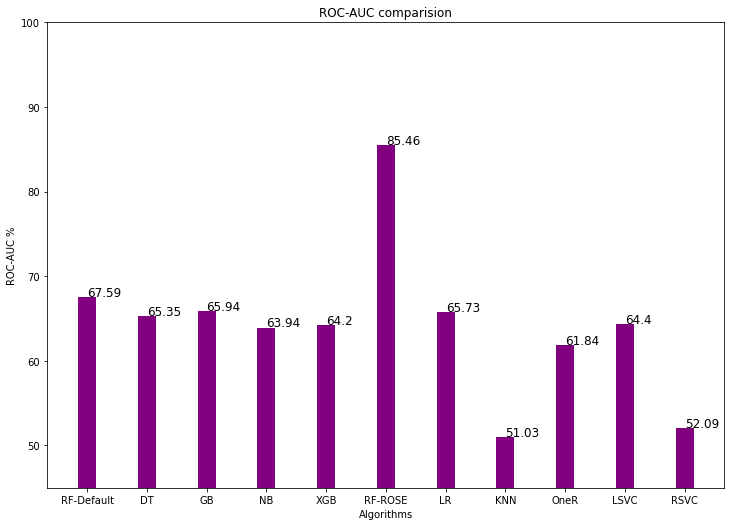

In [32]:
#ROC-AUC plot

fig, ax = plt.subplots(figsize = (10,7))
ax.bar(metrics_df['ModelName'],metrics_df['ROC_AUC'],width=0.3, color='purple')

for index,data in enumerate(metrics_df['ROC_AUC']):
    plt.text(x=index, y =data+0.1 , s=f"{data}" , fontdict=dict(fontsize=12))
plt.tight_layout()
plt.xlabel('Algorithms')
plt.ylabel('ROC-AUC %')
plt.title('ROC-AUC comparision')
plt.ylim([45,100])
plt.show()

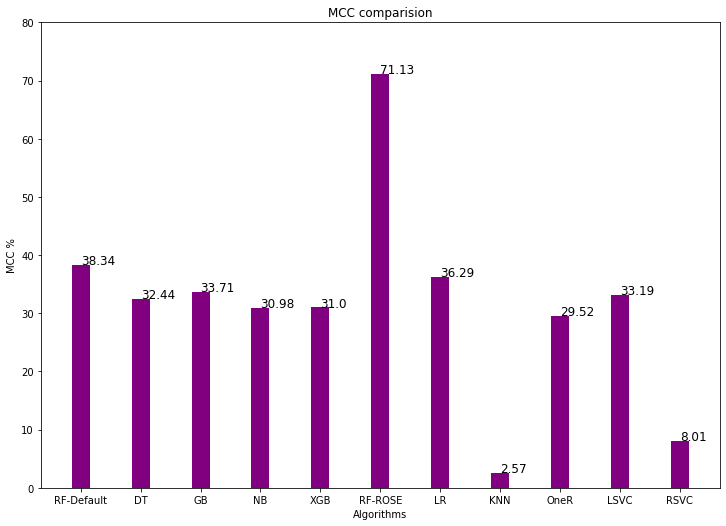

In [33]:
#MCC plot

fig, ax = plt.subplots(figsize = (10,7))
ax.bar(metrics_df['ModelName'],metrics_df['MCC'],width=0.3, color='purple')

for index,data in enumerate(metrics_df['MCC']):
    plt.text(x=index, y =data+0.1 , s=f"{data}" , fontdict=dict(fontsize=12))
plt.tight_layout()
plt.xlabel('Algorithms')
plt.ylabel('MCC %')
plt.title('MCC comparision')
plt.ylim([0,80])
plt.show()

<h3> Q2 - New Model Creation

In [34]:
patient_df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


<h6> Pre-processing

In [35]:
patient_df['Follow_Up_month'] = np.where(patient_df['time'] < 30, 0, None)
patient_df['Follow_Up_month'] = np.where((patient_df['time'] < 60) & (patient_df['time'] > 29), 1, patient_df['Follow_Up_month'])
patient_df['Follow_Up_month'] = np.where((patient_df['time'] < 90) & (patient_df['time'] > 59), 2, patient_df['Follow_Up_month'])
patient_df['Follow_Up_month'] = np.where((patient_df['time'] < 120) & (patient_df['time'] > 89), 3, patient_df['Follow_Up_month'])
patient_df['Follow_Up_month'] = np.where((patient_df['time'] < 150) & (patient_df['time'] > 119), 4, patient_df['Follow_Up_month'])
patient_df['Follow_Up_month'] = np.where((patient_df['time'] < 180) & (patient_df['time'] > 149), 5, patient_df['Follow_Up_month'])
patient_df['Follow_Up_month'] = np.where((patient_df['time'] < 210) & (patient_df['time'] > 179), 6, patient_df['Follow_Up_month'])
patient_df['Follow_Up_month'] = np.where((patient_df['time'] < 240) & (patient_df['time'] > 209), 7, patient_df['Follow_Up_month'])
patient_df['Follow_Up_month'] = np.where((patient_df['time'] < 270) & (patient_df['time'] > 239), 8, patient_df['Follow_Up_month'])
patient_df['Follow_Up_month'] = np.where((patient_df['time'] < 300) & (patient_df['time'] > 269), 9, patient_df['Follow_Up_month'])

patient_df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,Follow_Up_month
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1,0
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1,0
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1,0
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1,0
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1,0


In [36]:
X = patient_df.loc[:,patient_df.columns!="DEATH_EVENT"]
X = X.loc[:,X.columns!="time"]
y = patient_df['DEATH_EVENT'] 

print(X.shape)
print(y.shape)

(299, 12)
(299,)


In [37]:
bins = np.arange(X['age'].min(), X['age'].max(), 10)
bins = np.arange(X['age'].min(), 101, 10)
age_labels = [f"{i} - {i+10}" for i in list(bins[:-1])]
X['ageBins'] = pd.cut(X['age'], bins=bins, right=True, labels=age_labels, include_lowest=True)
X.drop(columns={'age'}, inplace=True)
print(X.shape)
X.head()

(299, 12)


,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,Follow_Up_month,ageBins
0,0,582,0,20,1,265000.00,1.9,130,1,0,0,70.0 - 80.0
1,0,7861,0,38,0,263358.03,1.1,136,1,0,0,50.0 - 60.0
2,0,146,0,20,0,162000.00,1.3,129,1,1,0,60.0 - 70.0
3,1,111,0,20,0,210000.00,1.9,137,1,0,0,40.0 - 50.0
4,1,160,1,20,0,327000.00,2.7,116,0,0,0,60.0 - 70.0


In [38]:
le = LabelEncoder()
le_cols = ['ageBins']
X1 = X.copy()
X1[le_cols] = X1.loc[:, le_cols].apply(le.fit_transform) #Applying LabelEncoding

minmax_scaler = MinMaxScaler()

X_minmax = minmax_scaler.fit_transform(X1)
X_minmax_df = pd.DataFrame(X_minmax, columns =X.columns)
print(X_minmax_df.shape)
X_minmax_df.head()

(299, 12)


,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,Follow_Up_month,ageBins
0,0.0,0.071319,0.0,0.090909,1.0,0.290823,0.157303,0.485714,1.0,0.0,0.0,0.6
1,0.0,1.000000,0.0,0.363636,0.0,0.288833,0.067416,0.657143,1.0,0.0,0.0,0.2
2,0.0,0.015693,0.0,0.090909,0.0,0.165960,0.089888,0.457143,1.0,1.0,0.0,0.4
3,1.0,0.011227,0.0,0.090909,0.0,0.224148,0.157303,0.685714,1.0,0.0,0.0,0.0
4,1.0,0.017479,1.0,0.090909,0.0,0.365984,0.247191,0.085714,0.0,0.0,0.0,0.4


<h6> Feature engineering

In [39]:

X_minmax_df['Sick_and_Smoking'] = np.where(((X_minmax_df['diabetes'] == 1) | (X_minmax_df['high_blood_pressure'] == 1)
                                            | (X_minmax_df['anaemia'] == 1)) & (X_minmax_df['smoking']==1), 1, 0)

In [40]:
#Make metrics dataset

metrics_df2 = pd.DataFrame({
    'Model' : [],
    'Accuracy' : [],
    'ROC_AUC' : [],
    'F1_Score' : [],
    'MCC' : [],
    'TPR' : [],
    'TNR' : []
})
metrics_df2

,Model,Accuracy,ROC_AUC,F1_Score,MCC,TPR,TNR


In [41]:
#ROSE
ros = RandomOverSampler(random_state=123)
X_res, y_res = ros.fit_sample(X_minmax_df, y)
y_res.value_counts()

0    203
1    203
Name: DEATH_EVENT, dtype: int64

<h6> Feature Ranking

In [42]:
#Selection of top 10 features
kfeaures = SelectKBest(chi2, k=10).fit(X_res, y_res)
kfeatures_df = pd.DataFrame({'Variables':list(X_res.columns),
                                     'FeatureScore':kfeaures.scores_})
kfeatures_df.sort_values(by='FeatureScore', ascending=False).head(10)

,Variables,FeatureScore
10,Follow_Up_month,27.243278
6,serum_creatinine,4.528791
11,ageBins,3.663680
3,ejection_fraction,3.441942
0,anaemia,1.951351
12,Sick_and_Smoking,0.727273
1,creatinine_phosphokinase,0.631359
7,serum_sodium,0.350049
9,smoking,0.196850
4,high_blood_pressure,0.182482


In [43]:
print(X_res.shape)
final_df = pd.concat([X_res, y_res], axis=1)
print(final_df.shape)
final_df.head(1)

(406, 13)
(406, 14)


,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,Follow_Up_month,ageBins,Sick_and_Smoking,DEATH_EVENT
0,0.0,0.071319,0.0,0.090909,1.0,0.290823,0.157303,0.485714,1.0,0.0,0.0,0.6,0,1


In [44]:
# Finding correlation with the response variable
correlation = final_df.corr()['DEATH_EVENT'].sort_values()

print('Top Positive Correlation:\n', correlation.tail(3))
print('------------------------------')
print('\n Top Negative Correlation:\n', correlation.head(2))
print('------------------------------')

Top Positive Correlation:
 ageBins             0.207512
serum_creatinine    0.278234
DEATH_EVENT         1.000000
Name: DEATH_EVENT, dtype: float64
------------------------------

 Top Negative Correlation:
 Follow_Up_month     -0.544998
ejection_fraction   -0.294925
Name: DEATH_EVENT, dtype: float64
------------------------------


<AxesSubplot:>

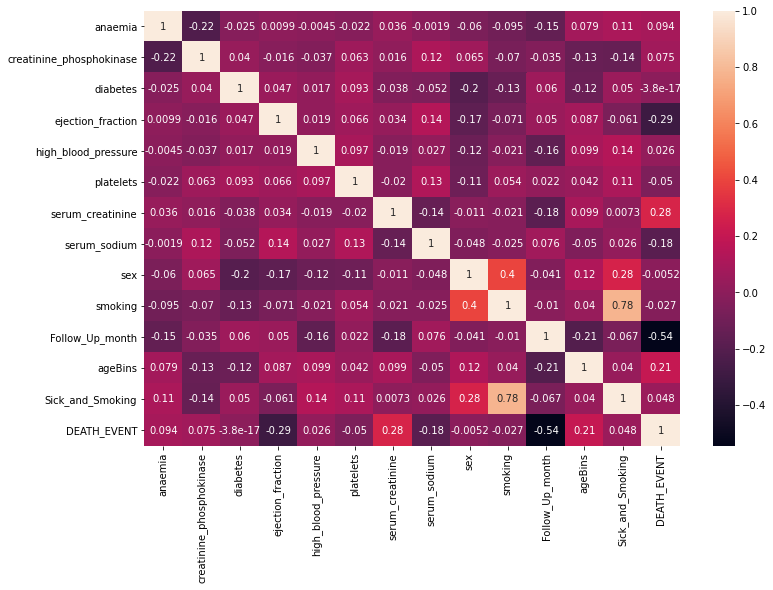

In [45]:
plt.figure(figsize=(12, 8))
sns.heatmap(final_df.corr(), annot=True)

In [46]:
X_res.drop(columns='smoking', inplace=True) #Multicollinear variable
print(X_res.shape)

(406, 12)


<h6> Model creation without hyperparameter tuning - Entire dataset

In [47]:
Classifiers = [
    ExtraTreesClassifier(verbose=0, random_state=123)
]


kf = StratifiedShuffleSplit(n_splits = 100, random_state = 100, test_size=0.2)
roc_score_list =[]
accuracy_score_list = []
f1_score_list = []
mcc_score_list = []
tpr_list = []
tnr_list = []
avg_auc_list = []
row_index= 0
for classifier in Classifiers:
    metrics_df2.loc[row_index, 'Model'] = classifier.__class__.__name__ 
    i=1
    for train_index,test_index in kf.split(X_res,y_res):
        X_train, X_test = X_res.loc[train_index], X_res.loc[test_index]
        y_train,y_test = y_res.loc[train_index],y_res.loc[test_index]

        #Model
        model = classifier
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        #ROC_AUC
        roc_score = roc_auc_score(y_test, y_pred)
        roc_score_list.append(roc_score)    

        #Accuracy
        accuracy_score_lr = metrics.accuracy_score(y_test, y_pred)
        accuracy_score_list.append(accuracy_score_lr)

        #F1-Score
        f1_score = metrics.f1_score(y_test, y_pred)
        f1_score_list.append(f1_score)

        #MCC
        mcc_score = metrics.matthews_corrcoef(y_test, y_pred)
        mcc_score_list.append(mcc_score)
        
         # compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        tpr = tp/(tp + fn)
        tpr_list.append(tpr)
        
        # specificity, selectivity or true negative rate (TNR)
        tnr = tn/(tn + fp)
        tnr_list.append(tnr)
        
        #PR-AUC
        average_precision = metrics.average_precision_score(y_test, y_pred)
        avg_auc_list.append(average_precision)
        
        i+=1
    metrics_df2.loc[row_index, 'Accuracy'] = round(np.mean(accuracy_score_lr) * 100,2) 
    metrics_df2.loc[row_index, 'ROC_AUC'] = round(np.mean(roc_score_list) * 100, 2)
    metrics_df2.loc[row_index, 'F1_Score'] = round(np.mean(f1_score_list) * 100, 2)
    metrics_df2.loc[row_index, 'MCC'] = round(np.mean(mcc_score_list) * 100, 2)
    metrics_df2.loc[row_index, 'TPR'] = round(np.mean(tpr_list) * 100, 2)
    metrics_df2.loc[row_index, 'TNR'] = round(np.mean(tnr_list) * 100, 2)
    metrics_df2.loc[row_index, 'PR_AUC'] = round(np.mean(avg_auc_list) * 100, 2)
    
    row_index+=1

In [48]:
metrics_df2

,Model,Accuracy,ROC_AUC,F1_Score,MCC,TPR,TNR,PR_AUC
0,ExtraTreesClassifier,86.59,90.82,90.88,81.88,91.88,89.76,86.87


<h6> Model building with Hyperparameter tuning.

In [49]:
#Make metrics dataset for hyperparameter

ext_hyper_df = pd.DataFrame({
    'n_estimators' : [],
    'Model' : [],
    'Accuracy' : [],
    'ROC_AUC' : [],
    'F1_Score' : [],
    'MCC' : [],
    'TPR' : [],
    'TNR' : []
})

ext_hyper_df

,n_estimators,Model,Accuracy,ROC_AUC,F1_Score,MCC,TPR,TNR


In [50]:
n_estimators = [100, 300, 500, 700, 900]

kf = ShuffleSplit(n_splits = 100, random_state = 100, test_size=0.2)
roc_score_ext =[]
accuracy_score_ext = []
f1_score_ext = []
mcc_score_ext = []
tpr_ext = []
tnr_ext = []
avg_auc_ext = []

row_index=0 #Adding to next row
iteration = 1

ext_hyper_df.loc[row_index, 'Model'] = 'ext'
for train_index,test_index in kf.split(X_res,y_res):
    X_train, X_test = X_res.loc[train_index], X_res.loc[test_index]
    y_train,y_test = y_res.loc[train_index],y_res.loc[test_index]
    
#     print(X_test.shape)
    for i in n_estimators:
        ext_hyper_df.loc[row_index, 'n_estimators'] = i
        #Model
        model = ExtraTreesClassifier(n_estimators=i, criterion='entropy', random_state=123)
        model.fit(X_train, y_train)
        y_pred_ext = model.predict(X_test)

        #ROC_AUC
        roc_score = roc_auc_score(y_test, y_pred_ext)
        roc_score_ext.append(roc_score)    

        #Accuracy
        accuracy_score_list = metrics.accuracy_score(y_test, y_pred_ext)
        accuracy_score_ext.append(accuracy_score_list)

        #F1-Score
        f1_score = metrics.f1_score(y_test, y_pred_ext)
        f1_score_ext.append(f1_score)

        #MCC
        mcc_score = metrics.matthews_corrcoef(y_test, y_pred_ext)
        mcc_score_ext.append(mcc_score)

         # compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_ext).ravel()
        tpr = tp/(tp + fn)
        tpr_ext.append(tpr)

        # specificity, selectivity or true negative rate (TNR)
        tnr = tn/(tn + fp)
        tnr_ext.append(tnr)

        #PR-AUC
        average_precision = metrics.average_precision_score(y_test, y_pred_ext)
        avg_auc_ext.append(average_precision)
        
        ext_hyper_df.loc[row_index, 'Accuracy'] = round(accuracy_score_list * 100, 2)
        ext_hyper_df.loc[row_index, 'ROC_AUC'] = round(roc_score * 100, 2)
        ext_hyper_df.loc[row_index, 'MCC'] = round(mcc_score * 100, 2)
        
        row_index+=1
        
    iteration+=1

In [51]:
#Grouping all the iteration by n_estimators and selecting best MCC Score value
ext_hyper_df.groupby('n_estimators').agg({'MCC':np.mean}).reset_index().sort_values(by='MCC', ascending=False).head(1)

,n_estimators,MCC
2,500.0,81.6338


Building model with best n_estimators value - parameter

In [52]:
Classifiers = [
    ExtraTreesClassifier(n_estimators=500, criterion='gini', random_state=123)
   ]


kf = StratifiedShuffleSplit(n_splits = 100, random_state = 100, test_size=0.2)
roc_score_list =[]
accuracy_score_list = []
f1_score_list = []
mcc_score_list = []
tpr_list = []
tnr_list = []
avg_auc_list = []
row_index= 1
for classifier in Classifiers:
    metrics_df2.loc[row_index, 'Model'] = classifier.__class__.__name__  + ' ' + 'Hyperparameter Tuning'
    i=1
    for train_index,test_index in kf.split(X_res,y_res):
        X_train, X_test = X_res.loc[train_index], X_res.loc[test_index]
        y_train,y_test = y_res.loc[train_index],y_res.loc[test_index]

        #Model
        model = classifier
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        #ROC_AUC
        roc_score = roc_auc_score(y_test, y_pred)
        roc_score_list.append(roc_score)    

        #Accuracy
        accuracy_score_lr = metrics.accuracy_score(y_test, y_pred)
        accuracy_score_list.append(accuracy_score_lr)

        #F1-Score
        f1_score = metrics.f1_score(y_test, y_pred)
        f1_score_list.append(f1_score)

        #MCC
        mcc_score = metrics.matthews_corrcoef(y_test, y_pred)
        mcc_score_list.append(mcc_score)
        
         # compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        tpr = tp/(tp + fn)
        tpr_list.append(tpr)
        
        # specificity, selectivity or true negative rate (TNR)
        tnr = tn/(tn + fp)
        tnr_list.append(tnr)
        
        #PR-AUC
        average_precision = metrics.average_precision_score(y_test, y_pred)
        avg_auc_list.append(average_precision)
        
        i+=1
    metrics_df2.loc[row_index, 'Accuracy'] = round(np.mean(accuracy_score_lr) * 100,2) 
    metrics_df2.loc[row_index, 'ROC_AUC'] = round(np.mean(roc_score_list) * 100, 2)
    metrics_df2.loc[row_index, 'F1_Score'] = round(np.mean(f1_score_list) * 100, 2)
    metrics_df2.loc[row_index, 'MCC'] = round(np.mean(mcc_score_list) * 100, 2)
    metrics_df2.loc[row_index, 'TPR'] = round(np.mean(tpr_list) * 100, 2)
    metrics_df2.loc[row_index, 'TNR'] = round(np.mean(tnr_list) * 100, 2)
    metrics_df2.loc[row_index, 'PR_AUC'] = round(np.mean(avg_auc_list) * 100, 2)
    
    row_index+=1

In [53]:
metrics_df2

,Model,Accuracy,ROC_AUC,F1_Score,MCC,TPR,TNR,PR_AUC
0,ExtraTreesClassifier,86.59,90.82,90.88,81.88,91.88,89.76,86.87
1,ExtraTreesClassifier Hyperparameter Tuning,86.59,91.12,91.18,82.45,92.00,90.24,87.33


<h6> Model with only 2 features

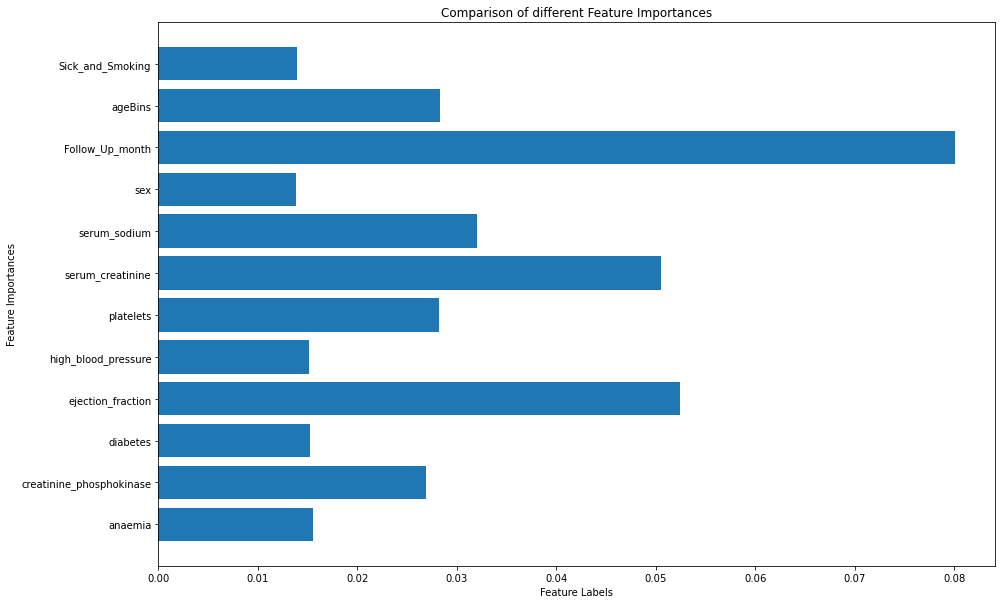

In [54]:
# Computing the importance of each feature
feature_importance = model.feature_importances_
  
# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        model.estimators_],
                                        axis = 0)

# Plotting a Bar Graph to compare the models
plt.figure(figsize=(15, 10))
plt.barh(X_res.columns, feature_importance_normalized)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

In [55]:
X_selected = X_res[['ejection_fraction', 'serum_creatinine', 'Follow_Up_month']]
X_selected.head()

,ejection_fraction,serum_creatinine,Follow_Up_month
0,0.090909,0.157303,0.0
1,0.363636,0.067416,0.0
2,0.090909,0.089888,0.0
3,0.090909,0.157303,0.0
4,0.090909,0.247191,0.0


In [56]:
Classifiers = [
    ExtraTreesClassifier(n_estimators=500, criterion='gini', random_state=123)
   ]


kf = StratifiedShuffleSplit(n_splits = 100, random_state = 100, test_size=0.2)
roc_score_list =[]
accuracy_score_list = []
f1_score_list = []
mcc_score_list = []
tpr_list = []
tnr_list = []
avg_auc_list = []
row_index= 2
for classifier in Classifiers:
    metrics_df2.loc[row_index, 'Model'] = classifier.__class__.__name__  + ' ' + 'Top 2 Features'
    i=1
    for train_index,test_index in kf.split(X_selected,y_res):
        X_train, X_test = X_selected.loc[train_index],X_selected.loc[test_index]
        y_train,y_test = y_res.loc[train_index],y_res.loc[test_index]

        #Model
        model = classifier
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        #ROC_AUC
        roc_score = roc_auc_score(y_test, y_pred)
        roc_score_list.append(roc_score)    

        #Accuracy
        accuracy_score_lr = metrics.accuracy_score(y_test, y_pred)
        accuracy_score_list.append(accuracy_score_lr)

        #F1-Score
        f1_score = metrics.f1_score(y_test, y_pred)
        f1_score_list.append(f1_score)

        #MCC
        mcc_score = metrics.matthews_corrcoef(y_test, y_pred)
        mcc_score_list.append(mcc_score)
        
         # compute confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        tpr = tp/(tp + fn)
        tpr_list.append(tpr)
        
        # specificity, selectivity or true negative rate (TNR)
        tnr = tn/(tn + fp)
        tnr_list.append(tnr)
        
        #PR-AUC
        average_precision = metrics.average_precision_score(y_test, y_pred)
        avg_auc_list.append(average_precision)
        
        i+=1
    metrics_df2.loc[row_index, 'Accuracy'] = round(np.mean(accuracy_score_lr) * 100,2) 
    metrics_df2.loc[row_index, 'ROC_AUC'] = round(np.mean(roc_score_list) * 100, 2)
    metrics_df2.loc[row_index, 'F1_Score'] = round(np.mean(f1_score_list) * 100, 2)
    metrics_df2.loc[row_index, 'MCC'] = round(np.mean(mcc_score_list) * 100, 2)
    metrics_df2.loc[row_index, 'TPR'] = round(np.mean(tpr_list) * 100, 2)
    metrics_df2.loc[row_index, 'TNR'] = round(np.mean(tnr_list) * 100, 2)
    metrics_df2.loc[row_index, 'PR_AUC'] = round(np.mean(avg_auc_list) * 100, 2)
    
    row_index+=1

In [57]:
metrics_df2['ModelName'] = np.where(metrics_df2['Model'] == "ExtraTreesClassifier", "ExtraTree-Default", None)
metrics_df2['ModelName'] = np.where(metrics_df2['Model'] == "ExtraTreesClassifier Hyperparameter Tuning", "ExtraTree", metrics_df2['ModelName'])
metrics_df2['ModelName'] = np.where(metrics_df2['Model'] == "ExtraTreesClassifier Top 2 Features", "ETree(Top 2)", metrics_df2['ModelName'])
metrics_df2

,Model,Accuracy,ROC_AUC,F1_Score,MCC,TPR,TNR,PR_AUC,ModelName
0,ExtraTreesClassifier,86.59,90.82,90.88,81.88,91.88,89.76,86.87,ExtraTree-Default
1,ExtraTreesClassifier Hyperparameter Tuning,86.59,91.12,91.18,82.45,92.00,90.24,87.33,ExtraTree
2,ExtraTreesClassifier Top 2 Features,82.93,90.57,90.85,81.46,93.37,87.78,86.07,ETree(Top 2)


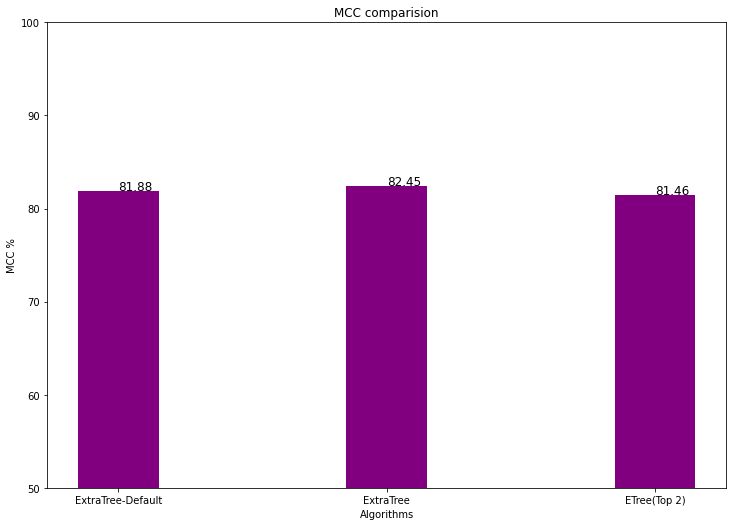

In [58]:
#MCC plot

fig, ax = plt.subplots(figsize = (10,7))
ax.bar(metrics_df2['ModelName'],metrics_df2['MCC'],width=0.3, color='purple')

for index,data in enumerate(metrics_df2['MCC']):
    plt.text(x=index, y =data+0.1 , s=f"{data}" , fontdict=dict(fontsize=12))
plt.tight_layout()
plt.xlabel('Algorithms')
plt.ylabel('MCC %')
plt.title('MCC comparision')
plt.ylim([50,100])
plt.show()

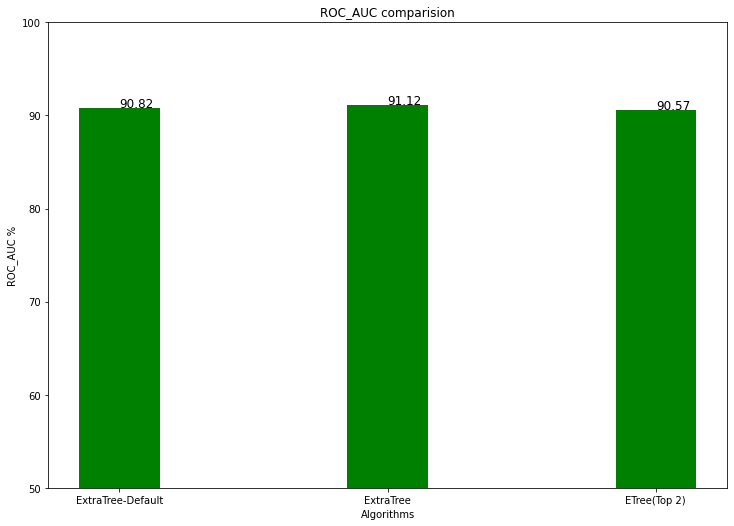

In [59]:
#MCC plot

fig, ax = plt.subplots(figsize = (10,7))
ax.bar(metrics_df2['ModelName'],metrics_df2['ROC_AUC'],width=0.3, color='green')

for index,data in enumerate(metrics_df2['ROC_AUC']):
    plt.text(x=index, y =data+0.1 , s=f"{data}" , fontdict=dict(fontsize=12))
plt.tight_layout()
plt.xlabel('Algorithms')
plt.ylabel('ROC_AUC %')
plt.title('ROC_AUC comparision')
plt.ylim([50,100])
plt.show()

![Alt Text](https://media.giphy.com/media/H4zC1A2FZ0ViA6GcxD/giphy.gif)